In [1]:
%retina

UsageError: Line magic function `%retina` not found.


In [1]:
pwd

'/private/home/jeanremi/project/jrr/code/meg_experiment'

In [2]:
%matplotlib inline

import os.path as op
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
import pickle
import time
import submitit
from scipy.stats import wilcoxon
import seaborn as sns
import pandas as pd
import mne
from copy import deepcopy

from sklearn.preprocessing import scale
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_1samp, wilcoxon
import spacy

from models import Forward, Backward, B2B, CCA, PLS, RegCCA, GridCCA, GridPLS, GridRegCCA, score_knockout
from common import log_files, data_path
from base import fetch_data

In [6]:
import warnings
warnings.simplefilter("ignore")

In [3]:
log_files = log_files.query('task=="visual"')
print(len(log_files))

100


In [4]:
def load_all(folder='jrr_iclr'):
    """Loop Granger score for each time sample independently"""
    
    X = list()
    Y = list()
    for _, subject in log_files.iterrows():
        print('.', end='')
        # Paths
        preproc_path = op.join(data_path, '..', folder, 
                               '%s-preproc.pkl' % subject.subject)

        # Load and preprocess data
        if not op.isfile(preproc_path):
            continue
            
        with open(preproc_path, 'rb') as f:
            meg, times, features, names, words = pickle.load(f)
        
        t400 = np.where(times>.400)[0][0]
        X.append(features)
        Y.append(meg[:, :, t400])
    
    return X, Y

In [41]:
def run(subject, model_name,
        folder='jrr_iclr', refit_knockout=False,
        word_emb=False):
    """Loop Granger score for each time sample independently"""
    start = time.time()
    print(start)
    
    # Paths
    preproc_path = op.join(data_path, '..', folder, 
                           '%s-preproc.pkl' % subject.subject)
    
    # Load and preprocess data
    if op.isfile(preproc_path):
        with open(preproc_path, 'rb') as f:
            meg, times, features, names, words = pickle.load(f)
    else:
        meg, times, features, names, words = fetch_data(subject)
        with open(preproc_path, 'wb') as f:
            pickle.dump([meg, times, features, names, words], f)
    
    cv = KFold(5, shuffle=True)    
    n_features = features.shape[1]
    _, n_channels, n_times = meg.shape
    
    if word_emb:
        nlp = spacy.load('nl_core_news_sm')
        embedding = scale([w.vector[:10] for w in map(nlp, words.values)])
        features = np.c_[features, embedding]
        n_features = features.shape[1]
    
    # Prepare model
    max_comp = min(meg.shape[1], n_features)
    comp_sweep = np.unique(np.floor(np.linspace(1, max_comp, 20))).astype(int)
    alpha_sweep = np.logspace(-4, 4, 20)

    models = dict(B2B=B2B(alpha_sweep),
                  B2B_ensemble=B2B(alpha_sweep, ensemble=20),
                  Backward=Backward(alpha_sweep),
                  Forward=Forward(alpha_sweep),
                  
                  CCA=GridCCA(comp_sweep),
                  RegCCA=GridRegCCA(alpha_sweep),
                  PLS=GridPLS(comp_sweep),
                  
                  CCA1=CCA(1),
                  CCA2=CCA(2),
                  CCA3=CCA(3),
                  CCA4=CCA(4),
                  CCA6=CCA(6),
                  
                  PLS1=PLS(1),
                  PLS2=PLS(2),
                  PLS3=PLS(3),
                  PLS4=PLS(4),
                  PLS6=PLS(6),
                 )
    
    print(subject.subject, model_name)


    scores_delta = np.zeros((cv.n_splits, n_times, n_features))

    # Loop across times
    scoring = 'r'
    
    for t in trange(n_times):
        for split, (train, test) in enumerate(cv.split(features)):
            # Preprocess
            X = StandardScaler().fit(features[train]).transform(features)
            Y = StandardScaler().fit(meg[train, :, t]).transform(meg[:, :, t])
            
            # Fit model
            model = models[model_name]
            model.fit(X[train], Y[train])
            # Compute standard scores
            XY_train = (X[train], Y[train]) if refit_knockout else None
            scores_delta[split, t] = score_knockout(model, X[test], Y[test], XY_train)
            
    # Mean scores across splits
    scores_delta = scores_delta.mean(0)
    
    # Save
    print('save')
    save_path = op.join(data_path, '..', folder, 
                        '%s-%s%s%s.pkl' % (subject.subject, model_name, 
                                         ['', '_refit'][refit_knockout],
                                         ['', '_wordemb'][word_emb]))
    with open(save_path, 'wb') as f:
        pickle.dump(scores_delta, f)

    print(time.time() - start)
    
    return scores_delta

In [121]:
folder = 'jrr_iclr'
preproc_path = op.join(data_path, '..', folder,
                       '%s-preproc.pkl' % log_files.iloc[0].subject)

In [122]:
log_path = op.join(data_path, '..', folder, 'log')
executor = submitit.AutoExecutor(folder=log_path)
executor.update_parameters(timeout_min=4*60, 
                           partition='learnfair,uninterrupted,scavenge',
                           constraint='pascal', cpus_per_task=10)

jobs = list()
models = (
    'B2B', 
    'Forward',
    'Backward',
    'CCA',
    'PLS',
    'RegCCA',
)

refit_wordemb = (
    (False, False), 
    (True, False), 
    (False, True)
)

for refit_knockout, word_emb in refit_wordemb:
    for subject in trange(len(log_files)):
        for model_name in models:
            subject_info = log_files.iloc[subject]
            
            save_path = op.join(data_path, '..', folder, '%s-%s%s%s.pkl') 
            if op.isfile(save_path % (subject_info.subject, model_name, 
                                      ['', '_refit'][refit_knockout],
                                      ['', '_wordemb'][word_emb])) and False:
                continue
            jobs.append([subject_info, model_name, folder, refit_knockout, word_emb])
print(len(jobs))
jobs = executor.map_array(run, *zip(*jobs))




  0%|          | 0/100 [00:00<?, ?it/s]


100%|██████████| 100/100 [00:00<00:00, 1340.17it/s]

100


In [123]:
times = np.linspace(-.100, 1., 67)

In [130]:
folder = 'jrr_iclr'

def get_results(model_name, folder=folder, refit_knockout=False, word_emb=False):
    
    scores = list()
    for subject in range(len(log_files)):
        subject = log_files.loc[subject, 'subject']
        save_path = op.join(data_path, '..', folder, 
                            '%s-%s%s%s.pkl' % (subject, model_name, 
                                           ['', '_refit'][refit_knockout],
                                           ['', '_wordemb'][word_emb]))
        if op.isfile(save_path):
            #print(save_path)
            with open(save_path, 'rb') as f:
                score = pickle.load(f)
            
            if isinstance(score, list):
                continue
            
            scores.append(score)

    return np.array(scores)

def get_all_results(refit_knockout=False, word_emb=False):
    models = [
          'Backward', 
          'Forward',
          'PLS',
          #'CCA',
          'RegCCA',
          'B2B',
          #'CCA2',
    ]

    data = list()
    for model_name in models:
        scores = get_results(model_name, refit_knockout=refit_knockout, word_emb=word_emb)
        features = ['Word Length', 'Word Frequency', 'Word Function', 'Dummy Variable']
        if scores.shape[2]>4:
            features.extend(['embedding %i' % i for i in range(scores.shape[2]-4)])
        print(model_name, len(scores))

        for effect_idx, effect in enumerate(features):
            for subject, score in enumerate(scores):
                for t_idx, (t, r) in enumerate(zip(times, score)):
                    score = scores[subject, t_idx, effect_idx]
                    data.append(dict(subject=subject, effect=effect, model=model_name, 
                                     r=score, time=int(t*1e3)))
    data = pd.DataFrame(data)
    return data

Backward 93
Forward 93
PLS 93
RegCCA 93
B2B 93
Backward 93
Forward 93
PLS 93
RegCCA 93
B2B 93


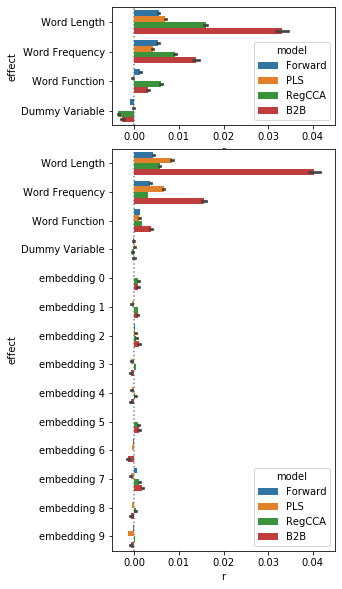

In [140]:
fig = plt.figure(figsize=[4, 10])
ax0 = plt.subplot(411)
ax1 = plt.subplot2grid((4, 1), (1, 0), rowspan=3)
data = get_all_results()
data = data.query('model!="Backward"')
sns.barplot(y='effect', x='r', orient='h',
            hue='model', data=data.query('time>0'), ax=ax0)
ax0.axvline(0, color='gray', ls=':', zorder=-1)
ax0.set_xlim(-.005, 0.045)

data = get_all_results(word_emb=True)
data = data.query('model!="Backward"')
sns.barplot(y='effect', x='r', orient='h',
            hue='model', data=data.query('time>0'), ax=ax1)
ax1.axvline(0, color='gray', ls=':', zorder=-1)
ax1.set_xlim(-.005, 0.045)

fig.savefig('compare_embeddings.pdf', bbox_inches='tight')

In [137]:
models

array(['Backward', 'Forward', 'PLS', 'RegCCA', 'B2B'], dtype=object)

Backward 93
Forward 93
PLS 93
RegCCA 93
B2B 93


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


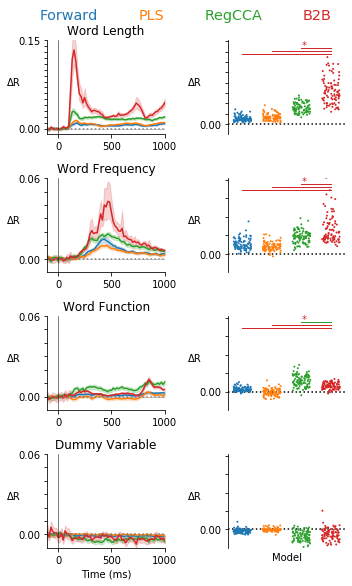

In [139]:
data = get_all_results()

data = data.query('model!="Backward"')
models = data.model.unique()

fig, axes = plt.subplots(4, 2, figsize=[5, 8])

for ax, effect in zip(axes[:, 0], features):
    sns.lineplot(x='time', y='r', hue='model', 
                 data=data.query('effect==@effect'),
                 ax=ax, legend=False)
    ax.axhline(0, color='gray', ls=':')

    ax.set_ylabel('ΔR').set_rotation(0)
    ax.axvline(0, color='k', lw=.5)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_title(effect)

    ylim = 0.06 if effect != 'Word Length' else 0.15
    ax.set_yticks(np.arange(0, ylim+.001, .01))
    ax.set_ylim(-.01, ylim)
    ax.set_yticklabels(['%.2f' % f if f in (0., ylim) else ''
                           for f in np.arange(0, ylim+.001, .01)])
    ax.set_xlim(-100, 1000)
    ax.axhline(0, color='k', ls=':', zorder=-10, lw=.5)
    ax.set_xlabel('')
ax.set_xlabel('Time (ms)')

for feature, ax in zip(features, axes[:, 1]):
    d = data.query('effect==@feature and time>0 and time <1000')
    d = d.groupby(('subject', 'model'), as_index=False).mean()
    sns.stripplot(x='model', y='r', dodge=True, order=models,
                  s=2, jitter=.3, data=d, ax=ax)
    # legend clean up
    ax.axhline(0,color='k', ls=':')
    ax.legend().set_visible(False)
    ylim = 0.041 if feature != 'Word Length' else 0.081
    ax.set_ylim(-.01, ylim)
    ax.set_yticks(np.arange(0, ylim+.001, .01))
    ax.set_yticklabels(['%.2f' % f if f in (0., ylim) else '' 
                        for f in np.arange(0, ylim+.001, .01)])
    ax.set_ylabel('ΔR').set_rotation(0)
    ax.set_xticks([])
    ax.set_xlabel('')
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
    # statistical comparison
    if feature == 'Dummy Variable':
        continue

    space = np.ptp(ax.get_ylim()) / 30
    k = 0
    for idx, m1 in enumerate(models):

        r = list()
        _, p = wilcoxon(d.query('model == @m1').r.values)
        # print('%s: %s: %.4f' % (feature, m1, p))
        
        for jdx, m2 in enumerate(models):
            if m1 == m2:
                continue
            r = list()
            d.query('model==@m1').r.values
            for _, subject in d.query('model in [@m1, @m2]').groupby('subject'):
                if len(subject)==2:
                    r.append([subject.query('model==@m1').r.values[0],
                              subject.query('model==@m2').r.values[0]])
            r1, r2 = np.transpose(r)
            u, p = wilcoxon(r1, r2)
            if m1 == 'B2B' and feature != 'dummy':
                #print('%s: b2b versus %s: %.4f' % (feature, m2, p))
                pass
            if p < .05 and 'B2B' == m2:
                k += 1
                y = .8 * ylim + k * space
                if np.median(r1) > np.median(r2):
                    color = 'C%i' % idx
                else:
                    color = 'C%i' % jdx
                    
                ax.plot(np.linspace(0, 4, 5)[[idx, jdx]], 
                        [y, y], color=color, lw=1.)
    ax.text(2, y, '*', color='C3')
ax.set_xlabel('Model')

# legend
lines = [ax.plot([0, 0], [0,0], color='C%i' % i)[0] for i in range(4)]
#lines = [ax.plot([0, 0], [0,0], color='w')[0]] + lines
leg = plt.figlegend(lines, models, loc='upper center', 
                    ncol=5, labelspacing=0., fontsize='x-large',
                    handlelength=0, frameon=False,
                    bbox_to_anchor=(0.5,1.025))

for line, text in zip(leg.get_lines(), leg.get_texts()):
    text.set_color(line.get_color())

fig.tight_layout()
fig.savefig('meg.pdf')

Backward 93
Forward 93
PLS 93
RegCCA 93
B2B 93


Text(0.5, 0, 'Time (ms)')

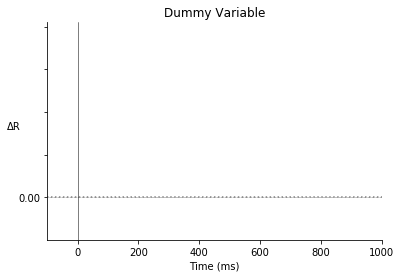

In [131]:
data = get_all_results()

fig, ax = plt.subplots(1)
sns.lineplot(x='time', y='r', hue='effect', 
             data=data.query('model=="Backward"'),
             legend=False)
ax.axhline(0, color='gray', ls=':')

ax.set_ylabel('ΔR').set_rotation(0)
ax.axvline(0, color='k', lw=.5)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_yticks(np.arange(0, ylim+.001, .01))
ax.set_ylim(-.01, ylim)
ax.set_yticklabels(['%.2f' % f if f in (0., ylim) else ''
                       for f in np.arange(0, ylim+.001, .01)])
ax.set_xlim(-100, 1000)
ax.axhline(0, color='k', ls=':', zorder=-10, lw=.5)
ax.set_xlabel('Time (ms)')
